In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import time
import rebound
import matplotlib.pyplot as plt
import numpy as np
import vanillaWH_bruteforce_noTransform_2body
import vanillaWH_bruteforce_noTransform_2body_solve_ivp
import vanillaWH_tools

import vanillaWH

%matplotlib inline

# configuring plots
#plt.rc('text', usetex=True)            # use LaTeX for text
plt.rc('font', family='serif')          # use serif font
plt.rcParams.update({'font.size': 14})  # increase font size

In [ ]:
#p0 = np.array([0., 0., 0., 0., 0., 0., 1.])
#p1 = np.array([1., 0., 0., 0., 1., 0., 1e-3])

sim = rebound.Simulation()
sim.add(m=1.)
sim.add(x=1., vy=1., m=1e-3)
sim.particles[1].e
sim.move_to_com()
sim.calculate_energy()

In [103]:
#ODE_methods = ['RK45', 'RK23', 'DOP853', 'Radau', 'BDF', 'LSODA']
ODE_methods = ['RK45']

# initial conditions from Mikkola 1997
# particle array as [x, y, z, vx, vy, vz, m]
#p0 = np.array([0., 0., 0., 0., 0., 0., 1.])
#p1 = np.array([-2., 0., 0., 0., -0.7, 0., 2.])
#p2 = np.array([0., 60., 0.01, -0.095, 0., 0.01, 0.9])

p0 = np.array([0., 0., 0., 0., 0., 0., 1.25])
p1 = np.array([1., 0., 0., 0., 1., 0., 1e-3])

sim_jacobi = np.stack([p0, p1])
masses = sim_jacobi[:,-1]

sim = vanillaWH_tools.jacobi_to_inertial(sim_jacobi, masses)
sim_jacobi = vanillaWH_tools.inertial_to_jacobi(sim)

N_orbits = 100
steps_per_orbit = 100
timestep = 1./steps_per_orbit * 2*np.pi
N_steps = N_orbits*steps_per_orbit

energy_error = np.zeros((len(ODE_methods), N_steps))
E0 = vanillaWH_tools.energy_fn(sim)

orbit_soln = np.zeros((len(ODE_methods), len(sim_jacobi), 3, N_steps)) # [method, object, position, N_steps]
orbit_soln[:,:,0,0], orbit_soln[:,:,1,0] = sim_jacobi[:,0], sim_jacobi[:,1]


for m, method in enumerate(ODE_methods):
    
    start = time.time()
    for i in range(N_steps):

        # drift
        sim_jacobi = vanillaWH_bruteforce_noTransform_2body_solve_ivp.drift(sim_jacobi, sim, h=timestep, method=method)
        sim = vanillaWH_tools.jacobi_to_inertial(sim_jacobi, masses)

        # kick
        #sim_jacobi = vanillaWH_bruteforce_noTransform_3body.kick(sim_jacobi, sim, h=timestep)

        # drift
        #sim_jacobi = vanillaWH_bruteforce_noTransform_3body.drift(sim_jacobi, sim, h=timestep/2)
        #sim = vanillaWH_tools.jacobi_to_inertial(sim_jacobi, masses)

        E = vanillaWH_tools.energy_fn(sim)
        energy_error[m, i] = np.abs((E-E0)/E0)

        orbit_soln[m, :, 0, i] = sim_jacobi[:,0]
        orbit_soln[m, :, 1, i] = sim_jacobi[:,1]
        orbit_soln[m, :, 2, i] = sim_jacobi[:,2]

    end = time.time()

    print('time to integrate =', np.round(end - start, 1), 's with', method)
    
energy_error_rk =    energy_error[0]

time to integrate = 9.5 s with RK45


RK45


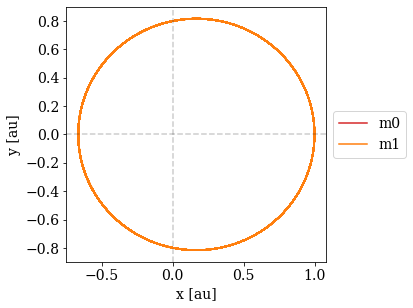

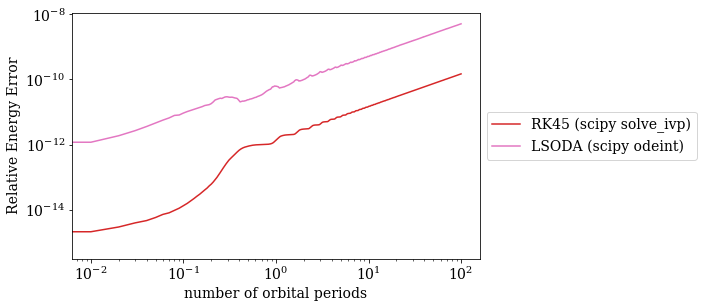

In [104]:
orbital_periods = np.arange(N_steps)/steps_per_orbit

for m, method in enumerate(ODE_methods):
    print(method)
    plt.figure(figsize=(10,4.5))
    plt.plot(orbit_soln[m,0,0], orbit_soln[m,0,1], label='m0', c='tab:red')
    plt.plot(orbit_soln[m,1,0], orbit_soln[m,1,1], label='m1', c='tab:orange')
    #plt.scatter(orbit_soln[2,0], orbit_soln[2,1], label='m2', c='tab:olive')

    plt.axhline(0, ls='--', alpha=0.2, c='black')
    plt.axvline(0, ls='--', alpha=0.2, c='black')
    plt.axis('scaled')
    #plt.xlim(-50,50)
    #plt.ylim(-10,90)
    plt.xlabel('x [au]')
    plt.ylabel('y [au]')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    #plt.savefig('SS.jpg', dpi=300)
    plt.show()

plt.figure(figsize=(10,4.5))
plt.loglog(orbital_periods, energy_error_rk, label='RK45 (scipy solve_ivp)', c='tab:red')
#plt.plot(orbital_periods, energy_error[1], label='RK23', c='tab:orange')
#plt.plot(orbital_periods, energy_error[2], label='DOP853', c='tab:olive')
#plt.plot(orbital_periods, energy_error[3], label='Radau', c='tab:green')
#plt.plot(orbital_periods, energy_error[4], label='BDF', c='tab:blue')
#plt.plot(orbital_periods, energy_error[5], label='LSODA', c='tab:purple')
plt.loglog(orbital_periods, energy_error2, label='LSODA (scipy odeint)', c='tab:pink')
#plt.yscale('log')
#plt.xlim(3e-1, 1e2)
#plt.ylim(1e-7, 1)
plt.xlabel('number of orbital periods')
plt.ylabel('Relative Energy Error')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig('comparison_ode.jpg', dpi=300)
plt.show()

#energy_error_rk = np.copy(energy_error)

In [32]:
# initial conditions from Mikkola 1997
# particle array as [x, y, z, vx, vy, vz, m]
#p0 = np.array([0., 0., 0., 0., 0., 0., 1.])
#p1 = np.array([-2., 0., 0., 0., -0.7, 0., 2.])
#p2 = np.array([0., 60., 0.01, -0.095, 0., 0.01, 0.9])

p0 = np.array([0., 0., 0., 0., 0., 0., 1.0])
p1 = np.array([1., 0., 0., 0., 1., 0., 1e-3])

sim_jacobi = np.stack([p0, p1])
masses = sim_jacobi[:,-1]

sim = vanillaWH_tools.jacobi_to_inertial(sim_jacobi, masses)
sim_jacobi = vanillaWH_tools.inertial_to_jacobi(sim)

period = 2*np.pi*np.sqrt(1/(1+1e-3))
print(period)

N_orbits = 10
steps_per_orbit = 100
timestep = 1./steps_per_orbit * period
N_steps = N_orbits*steps_per_orbit

energy_error = np.zeros(N_steps)
E0 = vanillaWH_tools.energy_fn(sim)
print(E0)

orbit_soln = np.zeros((len(sim_jacobi), 3, N_steps)) # [method, object, position, N_steps]
orbit_soln[:,0,0], orbit_soln[:,1,0] = sim_jacobi[:,0], sim_jacobi[:,1]

start = time.time()

for i in range(N_steps):

    # drift
    sim_jacobi = vanillaWH_bruteforce_noTransform_2body.drift(sim_jacobi, sim, h=timestep)
    sim = vanillaWH_tools.jacobi_to_inertial(sim_jacobi, masses)

    # kick
    #sim_jacobi = vanillaWH_bruteforce_noTransform_3body.kick(sim_jacobi, sim, h=timestep)

    # drift
    #sim_jacobi = vanillaWH_bruteforce_noTransform_3body.drift(sim_jacobi, sim, h=timestep/2)
    #sim = vanillaWH_tools.jacobi_to_inertial(sim_jacobi, masses)

    E = vanillaWH_tools.energy_fn(sim)
    #print(E)
    energy_error[i] = np.abs((E-E0)/E0)

    orbit_soln[:, 0, i] = sim_jacobi[:,0]
    orbit_soln[:, 1, i] = sim_jacobi[:,1]
    orbit_soln[:, 2, i] = sim_jacobi[:,2]

end = time.time()

print('time to integrate =', np.round(end - start, 1), 's')

6.2800460687587085
-0.0005004995004995004
time to integrate = 0.3 s


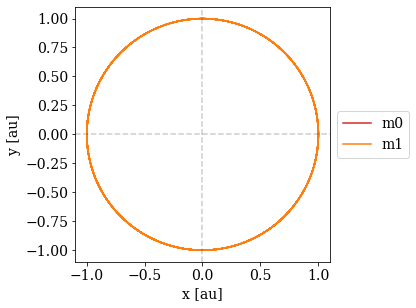

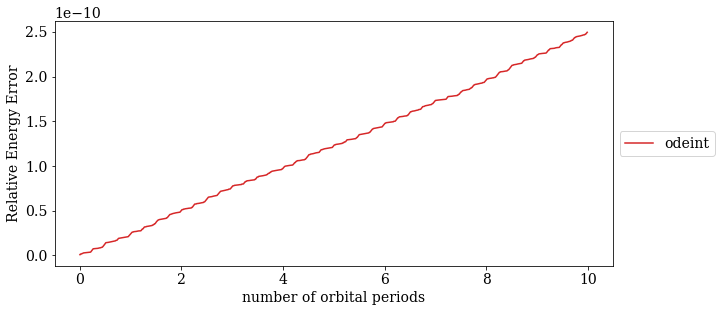

In [33]:
orbital_periods = np.arange(N_steps)/steps_per_orbit

plt.figure(figsize=(10,4.5))
plt.plot(orbit_soln[0,0], orbit_soln[0,1], label='m0', c='tab:red')
plt.plot(orbit_soln[1,0], orbit_soln[1,1], label='m1', c='tab:orange')
#plt.scatter(orbit_soln[2,0], orbit_soln[2,1], label='m2', c='tab:olive')

plt.axhline(0, ls='--', alpha=0.2, c='black')
plt.axvline(0, ls='--', alpha=0.2, c='black')
plt.axis('scaled')
#plt.xlim(-50,50)
#plt.ylim(-10,90)
plt.xlabel('x [au]')
plt.ylabel('y [au]')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
#plt.savefig('SS.jpg', dpi=300)
plt.show()

plt.figure(figsize=(10,4.5))
plt.plot(orbital_periods, energy_error, label='odeint', c='tab:red')
#plt.yscale('log')
#plt.ylim(-6e-5, 6e-5)
#plt.yscale('log')
plt.xlabel('number of orbital periods')
plt.ylabel('Relative Energy Error')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.tight_layout()
#plt.savefig('SS_energy_error.jpg', dpi=300)
plt.show()

energy_error2 = np.copy(energy_error)

In [113]:
# initial conditions from Mikkola 1997
# particle array as [x, y, z, vx, vy, vz, m]
#p0 = np.array([0., 0., 0., 0., 0., 0., 1.])
#p1 = np.array([-2., 0., 0., 0., -0.7, 0., 2.])
#p2 = np.array([0., 60., 0.01, -0.095, 0., 0.01, 0.9])

#p0 = np.array([0., 0., 0., 0., 0., 0., 2.])
#p1 = np.array([1., 0., 0., 0., 1., 0., 1e-9])

p0 = np.array([0., 0., 0., 0., 0., 0., 1.25])
p1 = np.array([1., 0., 0., 0., 1., 0., 1e-3])

sim_jacobi = np.stack([p0, p1])
masses = sim_jacobi[:,-1]

sim = vanillaWH_tools.jacobi_to_inertial(sim_jacobi, masses)
sim_jacobi = vanillaWH_tools.inertial_to_jacobi(sim)

N_orbits = 100
steps_per_orbit = 100
timestep = 1./steps_per_orbit * 2*np.pi
N_steps = N_orbits*steps_per_orbit

energy_error = np.zeros(N_steps)
E0 = vanillaWH_tools.energy_fn(sim)

orbit_soln = np.zeros((len(sim_jacobi), 3, N_steps)) # [method, object, position, N_steps]
orbit_soln[:,0,0], orbit_soln[:,1,0] = sim_jacobi[:,0], sim_jacobi[:,1]

start = time.time()

for i in range(N_steps):

    # drift
    sim_jacobi = vanillaWH_bruteforce_noTransform_2body.drift(sim_jacobi, sim, h=timestep)
    sim = vanillaWH_tools.jacobi_to_inertial(sim_jacobi, masses)

    # kick
    #sim_jacobi = vanillaWH_bruteforce_noTransform_3body.kick(sim_jacobi, sim, h=timestep)

    # drift
    #sim_jacobi = vanillaWH_bruteforce_noTransform_3body.drift(sim_jacobi, sim, h=timestep/2)
    #sim = vanillaWH_tools.jacobi_to_inertial(sim_jacobi, masses)

    E = vanillaWH_tools.energy_fn(sim)
    energy_error[i] = np.abs((E-E0)/E0)

    orbit_soln[:, 0, i] = sim_jacobi[:,0]
    orbit_soln[:, 1, i] = sim_jacobi[:,1]
    orbit_soln[:, 2, i] = sim_jacobi[:,2]

end = time.time()

print('time to integrate =', np.round(end - start, 1), 's')

time to integrate = 3.2 s


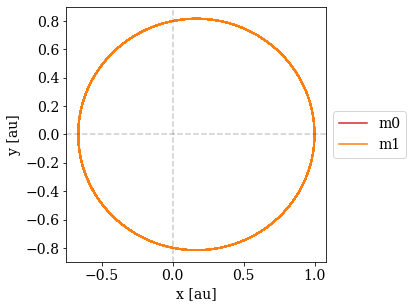

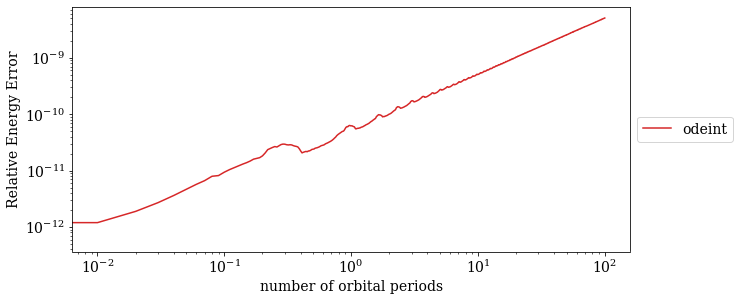

In [114]:
orbital_periods = np.arange(N_steps)/steps_per_orbit

plt.figure(figsize=(10,4.5))
plt.plot(orbit_soln[0,0], orbit_soln[0,1], label='m0', c='tab:red')
plt.plot(orbit_soln[1,0], orbit_soln[1,1], label='m1', c='tab:orange')
#plt.scatter(orbit_soln[2,0], orbit_soln[2,1], label='m2', c='tab:olive')

plt.axhline(0, ls='--', alpha=0.2, c='black')
plt.axvline(0, ls='--', alpha=0.2, c='black')
plt.axis('scaled')
#plt.xlim(-50,50)
#plt.ylim(-10,90)
plt.xlabel('x [au]')
plt.ylabel('y [au]')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
#plt.savefig('SS.jpg', dpi=300)
plt.show()

plt.figure(figsize=(10,4.5))
plt.loglog(orbital_periods, energy_error, label='odeint', c='tab:red')
#plt.yscale('log')
#plt.ylim(-6e-5, 6e-5)
plt.xlabel('number of orbital periods')
plt.ylabel('Relative Energy Error')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.tight_layout()
#plt.savefig('SS_energy_error.jpg', dpi=300)
plt.show()

energy_error2 = np.copy(energy_error)

In [ ]:
# initial conditions from Mikkola 1997
# particle array as [x, y, z, vx, vy, vz, m]
#p0 = np.array([0., 0., 0., 0., 0., 0., 1.])
#p1 = np.array([-2., 0., 0., 0., -0.7, 0., 2.])
#p2 = np.array([0., 60., 0.01, -0.095, 0., 0.01, 0.9])

#p0 = np.array([0., 0., 0., 0., 0., 0., 2.])
#p1 = np.array([1., 0., 0., 0., 1., 0., 1e-9])

p0 = np.array([0., 0., 0., 0., 0., 0., 1.])
p1 = np.array([1., 0., 0., 0., 1., 0., 1e-3])

p0 = np.array([0., 0., 0., 0., 0., 0., 1.25])
p1 = np.array([1., 0., 0., 0., 1., 0., 1e-3])

sim_jacobi = np.stack([p0, p1])
masses = sim_jacobi[:,-1]

sim = vanillaWH_tools.jacobi_to_inertial(sim_jacobi, masses)
sim_jacobi = vanillaWH_tools.inertial_to_jacobi(sim)

N_orbits = 100
steps_per_orbit = 200
timestep = 1./steps_per_orbit * 2*np.pi
N_steps = N_orbits*steps_per_orbit

energy_error = np.zeros(N_steps)
E0 = vanillaWH_tools.energy_fn(sim)

orbit_soln = np.zeros((len(sim_jacobi), 3, N_steps)) # [method, object, position, N_steps]
orbit_soln[:,0,0], orbit_soln[:,1,0] = sim_jacobi[:,0], sim_jacobi[:,1]

start = time.time()

for i in range(N_steps):

    # drift
    sim_jacobi = vanillaWH_bruteforce_noTransform_2body.drift_euler(sim_jacobi, sim, h=timestep)
    sim = vanillaWH_tools.jacobi_to_inertial(sim_jacobi, masses)

    # kick
    #sim_jacobi = vanillaWH_bruteforce_noTransform_3body.kick(sim_jacobi, sim, h=timestep)

    # drift
    #sim_jacobi = vanillaWH_bruteforce_noTransform_3body.drift(sim_jacobi, sim, h=timestep/2)
    #sim = vanillaWH_tools.jacobi_to_inertial(sim_jacobi, masses)

    E = vanillaWH_tools.energy_fn(sim)
    energy_error[i] = np.abs((E-E0)/E0)

    orbit_soln[:, 0, i] = sim_jacobi[:,0]
    orbit_soln[:, 1, i] = sim_jacobi[:,1]
    orbit_soln[:, 2, i] = sim_jacobi[:,2]

end = time.time()

print('time to integrate =', np.round(end - start, 1), 's')

In [ ]:
orbital_periods = np.arange(N_steps)/steps_per_orbit

plt.figure(figsize=(10,4.5))
plt.plot(orbit_soln[0,0], orbit_soln[0,1], label='m0', c='tab:red')
plt.plot(orbit_soln[1,0], orbit_soln[1,1], label='m1', c='tab:orange')
#plt.scatter(orbit_soln[2,0], orbit_soln[2,1], label='m2', c='tab:olive')

plt.axhline(0, ls='--', alpha=0.2, c='black')
plt.axvline(0, ls='--', alpha=0.2, c='black')
plt.axis('scaled')
#plt.xlim(-50,50)
#plt.ylim(-10,90)
plt.xlabel('x [au]')
plt.ylabel('y [au]')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
#plt.savefig('SS.jpg', dpi=300)
plt.show()

plt.figure(figsize=(10,4.5))
plt.loglog(orbital_periods, energy_error, label='Euler', c='tab:red')
#plt.yscale('log')
#plt.ylim(-6e-5, 6e-5)
plt.xlim(1e0, 1e2)
plt.ylim(1e-3, 1)
plt.xlabel('number of orbital periods')
plt.ylabel('Relative Energy Error')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.tight_layout()
#plt.savefig('SS_energy_error.jpg', dpi=300)
plt.show()

energy_error2 = np.copy(energy_error)

In [ ]:
# initial conditions from Mikkola 1997
# particle array as [x, y, z, vx, vy, vz, m]
#p0 = np.array([0., 0., 0., 0., 0., 0., 1.])
#p1 = np.array([-2., 0., 0., 0., -0.7, 0., 2.])
#p2 = np.array([0., 60., 0.01, -0.095, 0., 0.01, 0.9])

#p0 = np.array([0., 0., 0., 0., 0., 0., 2.])
#p1 = np.array([1., 0., 0., 0., 1., 0., 1e-9])

p0 = np.array([0., 0., 0., 0., 0., 0., 1.25])
p1 = np.array([1., 0., 0., 0., 1., 0., 1e-3])

sim_jacobi = np.stack([p0, p1])
masses = sim_jacobi[:,-1]

sim = vanillaWH_tools.jacobi_to_inertial(sim_jacobi, masses)
sim_jacobi = vanillaWH_tools.inertial_to_jacobi(sim)

N_orbits = 100
steps_per_orbit = 200
timestep = 1./steps_per_orbit * 2*np.pi
N_steps = N_orbits*steps_per_orbit

energy_error = np.zeros(N_steps)
E0 = vanillaWH_tools.energy_fn(sim)

orbit_soln = np.zeros((len(sim_jacobi), 3, N_steps)) # [method, object, position, N_steps]
orbit_soln[:,0,0], orbit_soln[:,1,0] = sim_jacobi[:,0], sim_jacobi[:,1]

start = time.time()

for i in range(N_steps):

    # drift
    sim_jacobi = vanillaWH.drift(sim_jacobi, sim, object_num=1, h=timestep)
    sim = vanillaWH_tools.jacobi_to_inertial(sim_jacobi, masses)

    # kick
    #sim_jacobi = vanillaWH_bruteforce_noTransform_3body.kick(sim_jacobi, sim, h=timestep)

    # drift
    #sim_jacobi = vanillaWH_bruteforce_noTransform_3body.drift(sim_jacobi, sim, h=timestep/2)
    #sim = vanillaWH_tools.jacobi_to_inertial(sim_jacobi, masses)

    E = vanillaWH_tools.energy_fn(sim)
    energy_error[i] = np.abs((E-E0)/E0)

    orbit_soln[:, 0, i] = sim_jacobi[:,0]
    orbit_soln[:, 1, i] = sim_jacobi[:,1]
    orbit_soln[:, 2, i] = sim_jacobi[:,2]

end = time.time()

print('time to integrate =', np.round(end - start, 1), 's')

In [ ]:
orbital_periods = np.arange(N_steps)/steps_per_orbit

plt.figure(figsize=(10,4.5))
plt.plot(orbit_soln[0,0], orbit_soln[0,1], label='m0', c='tab:red')
plt.plot(orbit_soln[1,0], orbit_soln[1,1], label='m1', c='tab:orange')
#plt.scatter(orbit_soln[2,0], orbit_soln[2,1], label='m2', c='tab:olive')

plt.axhline(0, ls='--', alpha=0.2, c='black')
plt.axvline(0, ls='--', alpha=0.2, c='black')
plt.axis('scaled')
#plt.xlim(-50,50)
#plt.ylim(-10,90)
plt.xlabel('x [au]')
plt.ylabel('y [au]')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
#plt.savefig('SS.jpg', dpi=300)
plt.show()

plt.figure(figsize=(10,4.5))
plt.loglog(orbital_periods, energy_error, label='odeint', c='tab:red')
#plt.yscale('log')
#plt.ylim(-6e-5, 6e-5)
plt.xlabel('number of orbital periods')
plt.ylabel('Relative Energy Error')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.tight_layout()
#plt.savefig('SS_energy_error.jpg', dpi=300)
plt.show()

energy_error2 = np.copy(energy_error)

In [60]:
# initial conditions from Mikkola 1997
# particle array as [x, y, z, vx, vy, vz, m]
#p0 = np.array([0., 0., 0., 0., 0., 0., 1.])
#p1 = np.array([-2., 0., 0., 0., -0.7, 0., 2.])
#p2 = np.array([0., 60., 0.01, -0.095, 0., 0.01, 0.9])

#p0 = np.array([0., 0., 0., 0., 0., 0., 2.])
#p1 = np.array([1., 0., 0., 0., 1., 0., 1e-9])

p0 = np.array([0., 0., 0., 0., 0., 0., 1.25])
p1 = np.array([1., 0., 0., 0., 1., 0., 1e-3])

sim_jacobi = np.stack([p0, p1])
masses = sim_jacobi[:,-1]

sim = vanillaWH_tools.jacobi_to_inertial(sim_jacobi, masses)
sim_jacobi = vanillaWH_tools.inertial_to_jacobi(sim)

N_orbits = 10
steps_per_orbit = 100
timestep = 1./steps_per_orbit * 2*np.pi
N_steps = N_orbits*steps_per_orbit

energy_error = np.zeros(N_steps)
E0 = vanillaWH_tools.energy_fn(sim)

orbit_soln = np.zeros((len(sim_jacobi), 3, N_steps)) # [method, object, position, N_steps]
orbit_soln[:,0,0], orbit_soln[:,1,0] = sim_jacobi[:,0], sim_jacobi[:,1]

start = time.time()

# drift
sol1 = vanillaWH_bruteforce_noTransform_2body.drift_multistep(sim_jacobi, sim, h=timestep, N_steps=N_steps)
#sim = vanillaWH_tools.jacobi_to_inertial(sim_jacobi, masses)

# kick
#sim_jacobi = vanillaWH_bruteforce_noTransform_3body.kick(sim_jacobi, sim, h=timestep)

# drift
#sim_jacobi = vanillaWH_bruteforce_noTransform_3body.drift(sim_jacobi, sim, h=timestep/2)
#sim = vanillaWH_tools.jacobi_to_inertial(sim_jacobi, masses)

#E = vanillaWH_tools.energy_fn(sim)
#energy_error[i] = np.abs((E-E0)/E0)
for i in range(N_steps):
    
    m2_jacobi = sim_jacobi[1,6]
    
    sim_jacobi[1,0] = sol1[i,0]
    sim_jacobi[1,1] = sol1[i,1]
    sim_jacobi[1,2] = sol1[i,2]
    sim_jacobi[1,3] = sol1[i,3]/m2_jacobi
    sim_jacobi[1,4] = sol1[i,4]/m2_jacobi
    sim_jacobi[1,5] = sol1[i,5]/m2_jacobi
    
    sim = vanillaWH_tools.jacobi_to_inertial(sim_jacobi, masses)
    E = vanillaWH_tools.energy_fn(sim)
    energy_error[i] = np.abs((E-E0)/E0)
    
orbit_soln[:, 0] = sol1[:,0]
orbit_soln[:, 1] = sol1[:,1]
orbit_soln[:, 2] = sol1[:,2]

end = time.time()

print('time to integrate =', np.round(end - start, 1), 's')

time to integrate = 0.1 s


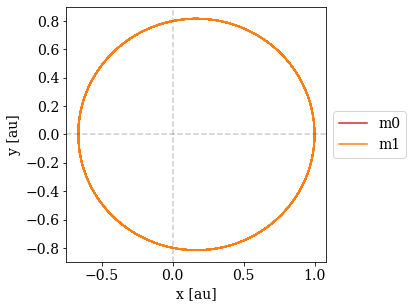

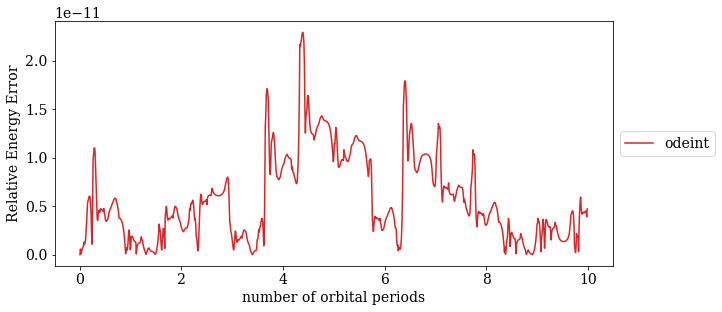

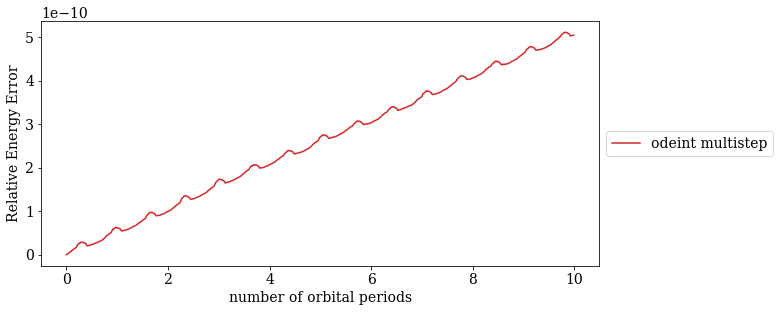

In [61]:
orbital_periods = np.arange(N_steps)/steps_per_orbit

plt.figure(figsize=(10,4.5))
plt.plot(orbit_soln[0,0], orbit_soln[0,1], label='m0', c='tab:red')
plt.plot(orbit_soln[1,0], orbit_soln[1,1], label='m1', c='tab:orange')
#plt.scatter(orbit_soln[2,0], orbit_soln[2,1], label='m2', c='tab:olive')

plt.axhline(0, ls='--', alpha=0.2, c='black')
plt.axvline(0, ls='--', alpha=0.2, c='black')
plt.axis('scaled')
#plt.xlim(-50,50)
#plt.ylim(-10,90)
plt.xlabel('x [au]')
plt.ylabel('y [au]')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
#plt.savefig('SS.jpg', dpi=300)
plt.show()

plt.figure(figsize=(10,4.5))
plt.plot(orbital_periods, energy_error, label='odeint', c='tab:red')
#plt.yscale('log')
#plt.ylim(-6e-5, 6e-5)
plt.xlabel('number of orbital periods')
plt.ylabel('Relative Energy Error')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.tight_layout()
#plt.savefig('SS_energy_error.jpg', dpi=300)
plt.show()

plt.figure(figsize=(10,4.5))
plt.plot(orbital_periods, energy_error2, label='odeint multistep', c='tab:red')
#plt.yscale('log')
#plt.ylim(-6e-5, 6e-5)
plt.xlabel('number of orbital periods')
plt.ylabel('Relative Energy Error')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.tight_layout()
#plt.savefig('SS_energy_error.jpg', dpi=300)
plt.show()

#energy_error2 = np.copy(energy_error)

#energy_error2 = np.copy(energy_error)

In [31]:
energy_error2

array([0.00000000e+00, 7.60350334e-13, 5.00401502e-14, 6.30375918e-14,
       1.32140656e-14, 5.97882314e-14, 9.66143160e-14, 3.39883098e-13,
       4.00104578e-13, 1.55969299e-13, 1.13727614e-13, 1.22392575e-13,
       1.31490784e-13, 1.46221218e-13, 1.93012008e-13, 1.75898710e-13,
       1.29324544e-13, 9.59644439e-14, 8.59997387e-14, 8.05841380e-14,
       7.40854172e-14, 6.82365685e-14, 6.06547275e-14, 9.09820913e-15,
       4.48411736e-14, 9.63976920e-14, 1.49687203e-13, 2.03843209e-13,
       2.62548321e-13, 3.28618649e-13, 4.02270818e-13, 4.83288204e-13,
       5.74486919e-13, 6.66335507e-13, 6.75433716e-13, 7.43453660e-13,
       7.83745729e-13, 8.32486135e-13, 8.88591758e-13, 9.40798149e-13,
       9.96253900e-13, 1.05604213e-12, 1.11561374e-12, 1.17756821e-12,
       1.23822294e-12, 1.29411194e-12, 1.35671628e-12, 1.41715438e-12,
       1.47997535e-12, 1.54474594e-12, 1.60973314e-12, 1.67688659e-12,
       1.74425666e-12, 1.81249323e-12, 1.88137967e-12, 1.95004949e-12,
      